In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import numpy as np

# Read the CSV file into a Pandas DataFrame
file_path = '/content/used_device_data.csv'
df = pd.read_csv(file_path)

In [ ]:
print(df.sample(10))

     device_brand       os  screen_size   4g  5g  rear_camera_mp  \
281       Infinix  Android        15.39  yes  no             NaN   
2012     Motorola  Android        12.75  yes  no           21.00   
2128         Oppo  Android        16.28  yes  no           13.00   
2646      Samsung  Android        10.16   no  no            5.00   
601        Others  Android        10.34   no  no           16.00   
2451      Samsung  Android        17.78  yes  no            5.00   
1390       Huawei  Android        10.29   no  no            3.15   
2932       Xiaomi  Android        15.70  yes  no           13.00   
1982     Motorola  Android        12.83  yes  no           13.00   
878        Others  Android        10.34   no  no            8.00   

      front_camera_mp  internal_memory  ram  battery  weight  release_year  \
281              16.0             32.0  3.0   4000.0   178.0          2019   
2012              2.0             32.0  4.0   3900.0   169.0          2014   
2128             

In [2]:
# Feature Intensive and Budget Friendly conditions
feature_intensive_condition = (
    (df['5g'] == 'yes') |
    (df['screen_size'] > df['screen_size'].median()) |
    (df['front_camera_mp'] > df['front_camera_mp'].median()) |
    (df['rear_camera_mp'] > df['rear_camera_mp'].median()) |
    (df['ram'] > df['ram'].median()) |
    (df['battery'] > df['battery'].median()) |
    (df['weight'] < df['weight'].median())
)

budget_friendly_condition = (
    (((df['normalized_new_price'] < df['normalized_new_price'].median()) | (df['normalized_new_price'] < df['normalized_new_price'].median()) |
    ((df['normalized_new_price'] - df['normalized_used_price']) < (df['normalized_new_price'] - df['normalized_used_price']).median()))) &
    (df['days_used'] < df['days_used'].median())
)

# Create new field 'Phone_Type' based on conditions
df['Phone_Type'] = 'Undecided'  # Default value
df.loc[feature_intensive_condition, 'Phone_Type'] = 'Feature_Intensive_Phone'
df.loc[budget_friendly_condition, 'Phone_Type'] = 'Budget_Friendly_Phone'

# Check unique values in the 'Phone_Type' column
phone_types = df['Phone_Type'].unique()
print("Unique Phone Types:", phone_types)


Unique Phone Types: ['Budget_Friendly_Phone' 'Feature_Intensive_Phone' 'Undecided']


In [3]:
# Count of each category in 'Phone_Type'
phone_type_counts = df['Phone_Type'].value_counts()
print("Count of each category in Phone_Type:")
print(phone_type_counts)

Count of each category in Phone_Type:
Feature_Intensive_Phone    2231
Budget_Friendly_Phone      1124
Undecided                    99
Name: Phone_Type, dtype: int64


In [4]:
print(df.sample(10))

     device_brand       os  screen_size   4g   5g  rear_camera_mp  \
912        Others  Android        12.83  yes   no           12.00   
2919       Xiaomi  Android        15.32  yes   no           12.00   
237         Honor  Android        14.50  yes   no           13.00   
3170          ZTE   Others        10.16   no   no            3.15   
2895       Others  Android        12.83  yes   no           13.00   
3405       Realme  Android        16.36  yes  yes             NaN   
2870         Vivo  Android        12.70  yes   no            8.00   
349          Oppo  Android        15.34  yes   no            8.00   
2866         Vivo  Android        12.88  yes   no           16.00   
2540      Samsung  Android         7.75   no   no            2.00   

      front_camera_mp  internal_memory  ram  battery  weight  release_year  \
912               8.0             64.0  4.0   3400.0   183.0          2017   
2919             13.0            128.0  4.0   4000.0   186.0          2019   
237   

In [5]:
# Rule-based classification
rule_based_class = df['Phone_Type']

In [6]:
# Assuming undecided_df is the DataFrame you want to export
df.to_csv('updateddf.csv', index=False)

In [7]:
# Define features and target variable
X = df.drop(['Phone_Type', 'device_brand', 'os'], axis=1)
y = df['Phone_Type']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Encode the class labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [9]:
# Define preprocessing steps
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [10]:
# Define the classifiers
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_classifier = XGBClassifier(random_state=42)
svm_classifier = SVC(kernel='linear', random_state=42)

In [11]:
# Create and evaluate pipelines
classifiers = {
    'Random Forest': rf_classifier,
    'XGBoost': xgb_classifier,
    'SVM': svm_classifier
}

for name, classifier in classifiers.items():
    # Create pipeline with preprocessing and classifier
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', classifier)])

    # Fit and evaluate the classifier
    pipeline.fit(X_train, y_train_encoded)
    y_pred = pipeline.predict(X_test)

    # Print results
    print(f"\n{name} Classifier:")
    print("Classification Report:")
    print(classification_report(y_test_encoded, y_pred))
    print("Accuracy Score:")
    print(accuracy_score(y_test_encoded, y_pred))


Random Forest Classifier:
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       221
           1       0.96      0.98      0.97       453
           2       1.00      0.76      0.87        17

    accuracy                           0.96       691
   macro avg       0.97      0.89      0.93       691
weighted avg       0.96      0.96      0.96       691

Accuracy Score:
0.9609261939218524

XGBoost Classifier:
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       221
           1       0.99      0.99      0.99       453
           2       1.00      1.00      1.00        17

    accuracy                           0.99       691
   macro avg       0.99      0.99      0.99       691
weighted avg       0.99      0.99      0.99       691

Accuracy Score:
0.9884225759768451

SVM Classifier:
Classification Report:
              precision    recall 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Random Forest Classifier on Validation Set:
Validation Accuracy Score: 0.9507959479015919

Random Forest Classifier on Testing Set:
Testing Accuracy Score: 0.9522431259044862


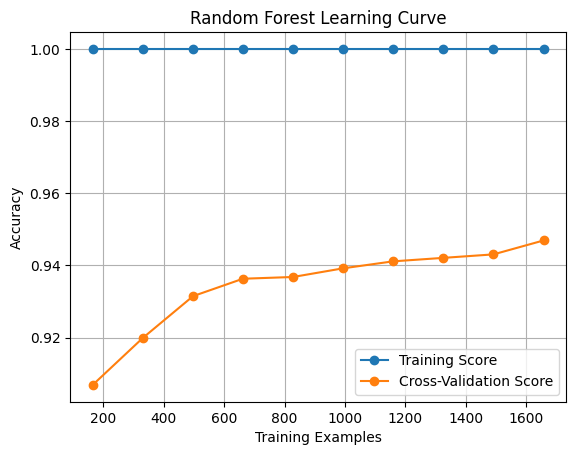


XGBoost Classifier on Validation Set:
Validation Accuracy Score: 0.9855282199710564

XGBoost Classifier on Testing Set:
Testing Accuracy Score: 0.9884225759768451


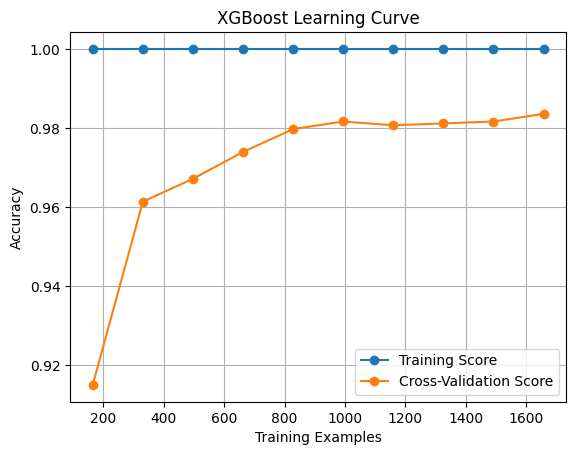


SVM Classifier on Validation Set:
Validation Accuracy Score: 0.8552821997105644

SVM Classifier on Testing Set:
Testing Accuracy Score: 0.8465991316931982


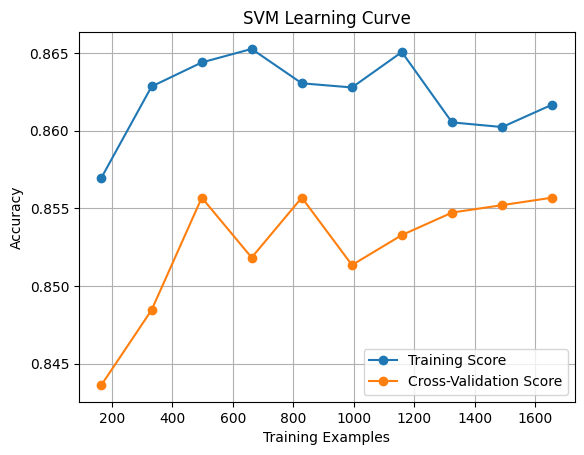

In [12]:
# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Encode the class labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Define preprocessing steps
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the classifiers
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_classifier = XGBClassifier(random_state=42)
svm_classifier = SVC(kernel='linear', random_state=42)

# Create and evaluate pipelines
classifiers = {
    'Random Forest': rf_classifier,
    'XGBoost': xgb_classifier,
    'SVM': svm_classifier
}

for name, classifier in classifiers.items():
    # Create pipeline with preprocessing and classifier
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', classifier)])

    # Fit the classifier on training set
    pipeline.fit(X_train, y_train_encoded)

    # Evaluate on validation set
    y_val_pred = pipeline.predict(X_val)
    val_accuracy = accuracy_score(y_val_encoded, y_val_pred)
    print(f"\n{name} Classifier on Validation Set:")
    print("Validation Accuracy Score:", val_accuracy)

    # Evaluate on testing set
    y_test_pred = pipeline.predict(X_test)
    test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
    print(f"\n{name} Classifier on Testing Set:")
    print("Testing Accuracy Score:", test_accuracy)

    # Plot learning curve
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes, train_scores, test_scores = learning_curve(pipeline, X_train, y_train_encoded, cv=5, train_sizes=train_sizes)

    plt.figure()
    plt.title(f"{name} Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("Accuracy")
    plt.grid()

    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Training Score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Cross-Validation Score")

    plt.legend(loc="best")
    plt.show()

In [13]:
# Create a new DataFrame for undecided entries
undecided_df = df[df['Phone_Type'] == 'Undecided'].copy()
# Replace the following line with your actual feature columns if different
X_undecided = undecided_df.drop(['Phone_Type', 'device_brand', 'os'], axis=1)

# Preprocess categorical features for prediction
X_undecided_processed = preprocessor.transform(X_undecided)

# Use your trained model to predict 'Phone_Type' for undecided entries
undecided_df['Predicted_Phone_Type'] = rf_classifier.predict(X_undecided_processed)

# Display the DataFrame with predicted values
print(undecided_df)

     device_brand       os  screen_size   4g  5g  rear_camera_mp  \
487       Alcatel  Android        12.83  yes  no             8.0   
501       Alcatel  Android        12.83  yes  no             8.0   
536       Alcatel  Android        12.70  yes  no             5.0   
547       Alcatel  Android        12.83   no  no             8.0   
562       Alcatel  Android        12.70   no  no             5.0   
...           ...      ...          ...  ...  ..             ...   
3091          ZTE  Android        12.83  yes  no             8.0   
3112          ZTE  Android        12.70   no  no             8.0   
3141          ZTE  Android        10.29   no  no             8.0   
3165          ZTE  Android        12.70   no  no             5.0   
3181          ZTE  Android        12.70   no  no             8.0   

      front_camera_mp  internal_memory  ram  battery  weight  release_year  \
487               5.0             16.0  4.0   2500.0   163.9          2016   
501               2.0      

In [14]:
# Assuming undecided_df is the DataFrame you want to export
undecided_df.to_csv('undecided_predictions.csv', index=False)
